In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import geodatasets

In [3]:
dtypes = {
    "date" : "str",
    "cell_ll_lat": "float32",
    "cell_ll_lon": "float32",
    "mmsi": "int32",
    "hours": "float32",
    "fishing_hours": "float32",
    "flag_registry": "category",
    "vessel_class_inferred": "category",
    "vessel_class_registry": "category",
    "vessel_class_gfw": "category",
    "vessel_class_inferred_score": "float32",
    "self_reported_fishing_vessel": "boolean",
    "length_m_inferred": "float32",
    "length_m_registry": "float32",
    "length_m_gfw": "float32",
    "engine_power_kw_inferred": "float32",
    "engine_power_kw_registry": "float32",
    "engine_power_kw_gfw": "float32",
    "tonnage_gt_inferred": "float32",
    "tonnage_gt_registry": "float32",
    "tonnage_gt_gfw": "float32",
    "fishing_hours_2019": "float32",
    "fishing_hours_2020": "float32"
}

df = pd.read_csv('MMSI-daily-merged_2019_2020-vessels.csv', dtype=dtypes)
print(df.head())

                  date  cell_ll_lat  cell_ll_lon       mmsi   hours  \
0  2019-01-01 00:00:00          0.0  -105.599998  224900000  0.2036   
1  2019-01-01 00:00:00          0.0  -105.300003  224900000  0.0205   
2  2019-01-01 00:00:00          0.0  -105.500000  224900000  0.9008   
3  2019-01-01 00:00:00          0.0  -105.400002  224900000  0.8638   
4  2019-01-01 00:00:00          0.0    -0.300000  228071900  0.7969   

   fishing_hours flag_registry vessel_class_inferred  \
0            0.0           ESP    drifting_longlines   
1            0.0           ESP    drifting_longlines   
2            0.0           ESP    drifting_longlines   
3            0.0           ESP    drifting_longlines   
4            0.0           FRA     tuna_purse_seines   

   vessel_class_inferred_score vessel_class_registry  ... length_m_registry  \
0                        0.987    drifting_longlines  ...             32.77   
1                        0.987    drifting_longlines  ...             32.77   

In [5]:
# List of Columns within the Dataset, size, and initial Dtypes
## No Null values in the position. However, alot of missing values of flag registry (important) and other characteristics like gear type. Fishing_hours for each year can be calculated if needed.
### We will need to drop values that are missing the flag_registry variable and see what nulls we are left with.
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107207569 entries, 0 to 107207568
Data columns (total 23 columns):
 #   Column                        Dtype   
---  ------                        -----   
 0   date                          object  
 1   cell_ll_lat                   float32 
 2   cell_ll_lon                   float32 
 3   mmsi                          int32   
 4   hours                         float32 
 5   fishing_hours                 float32 
 6   flag_registry                 category
 7   vessel_class_inferred         category
 8   vessel_class_inferred_score   float32 
 9   vessel_class_registry         category
 10  vessel_class_gfw              category
 11  self_reported_fishing_vessel  boolean 
 12  length_m_inferred             float32 
 13  length_m_registry             float32 
 14  length_m_gfw                  float32 
 15  engine_power_kw_inferred      float32 
 16  engine_power_kw_registry      float32 
 17  engine_power_kw_gfw           float32 
 18

In [6]:
## Basic Statistics for Each Column before dropping
pd.set_option('display.float_format', '{:.2f}'.format)
print(df.describe())

       cell_ll_lat  cell_ll_lon          mmsi        hours  fishing_hours  \
count 107207569.00 107207569.00  107207569.00 107207569.00   107207569.00   
mean         25.80        34.61  382023417.78         2.98           0.96   
std          30.91        96.17  148902192.78         5.47           2.44   
min         -77.90      -180.00        128.00         0.00           0.00   
25%           4.70       -16.40  257205220.00         0.42           0.00   
50%          34.60        19.90  412328683.00         0.80           0.00   
75%          48.00       121.20  416639000.00         2.36           0.87   
max          81.70       179.90 1020002044.00        47.94          47.56   

       vessel_class_inferred_score  length_m_inferred  length_m_registry  \
count                 106791172.00       106791172.00        63033890.00   
mean                          0.86              34.93              40.44   
std                           0.15              18.50              21.75   
mi

In [7]:
df['date'] = pd.to_datetime(df['date'])

In [9]:
# No Duplicates in the Data
print(df.duplicated().sum())

0


In [10]:
# Dropping missing values for flag_registry 
## (For future exploration, we may be able to take the missing values and compare it to flag_gfw to see our performance compared to gfw neural network)
df.dropna(subset=['flag_registry'],inplace=True)

In [11]:
## Still missing some engine_power, length, vessel_class variables. Looks like hours/fishing hours were on average higher for dropped variables.
print(df.isnull().sum())
print(df.describe())

date                                   0
cell_ll_lat                            0
cell_ll_lon                            0
mmsi                                   0
hours                                  0
fishing_hours                          0
flag_registry                          0
vessel_class_inferred             416397
vessel_class_inferred_score       416397
vessel_class_registry             715381
vessel_class_gfw                       0
self_reported_fishing_vessel           0
length_m_inferred                 416397
length_m_registry                6386763
length_m_gfw                       63654
engine_power_kw_inferred          416397
engine_power_kw_registry        21145548
engine_power_kw_gfw               121350
tonnage_gt_inferred               416397
tonnage_gt_registry              3444942
tonnage_gt_gfw                     42841
fishing_hours_2019               2092715
fishing_hours_2020               1663916
dtype: int64
                                date  cell_l

In [12]:
# Recast date column to useable datetime format
df['date'] = pd.to_datetime(df['date'])

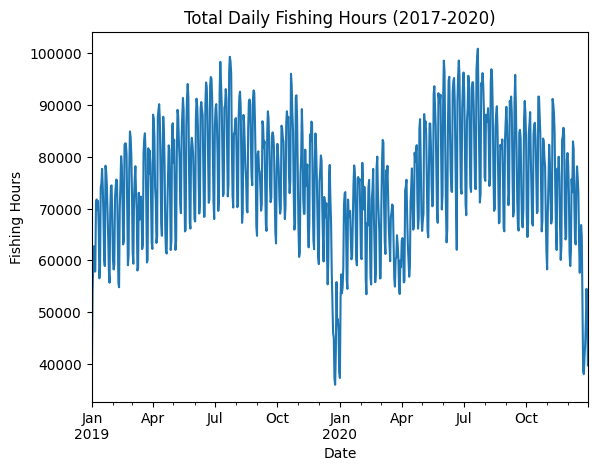

In [13]:
## Big drop in winter
df.groupby('date')['fishing_hours'].sum().plot(kind='line')
plt.title('Total Daily Fishing Hours (2017-2020)')
plt.xlabel('Date')
plt.ylabel('Fishing Hours')
plt.show()

In [14]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

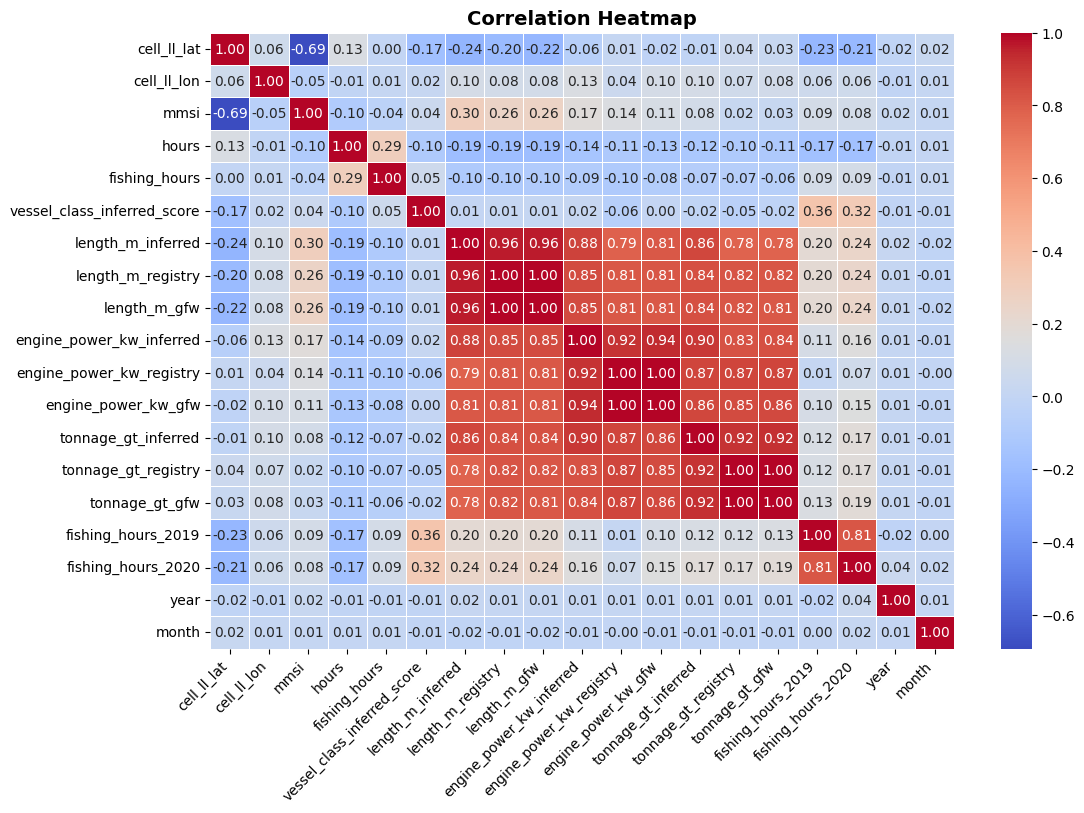

In [27]:
df_numeric = df.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 8))
sns.heatmap(
    df_numeric.corr(), 
    annot=True, 
    cmap='coolwarm', 
    fmt='.2f', 
    linewidths=0.5,
    annot_kws={"size": 10}
)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.title("Correlation Heatmap", fontsize=14, fontweight="bold")

plt.show()

<Axes: title={'center': 'Total Fishing Hours by Season (2019-2020)'}, xlabel='season'>

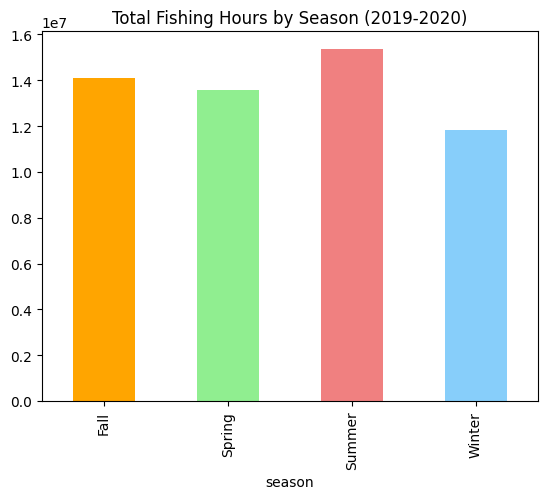

In [17]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

df['season'] = df['date'].dt.month.apply(get_season)

seasonal_fishing_hours = df.groupby('season')['fishing_hours'].sum()
seasonal_fishing_hours.plot(kind='bar', title='Total Fishing Hours by Season (2019-2020)', color=['orange', 'lightgreen', 'lightcoral', 'lightskyblue'])

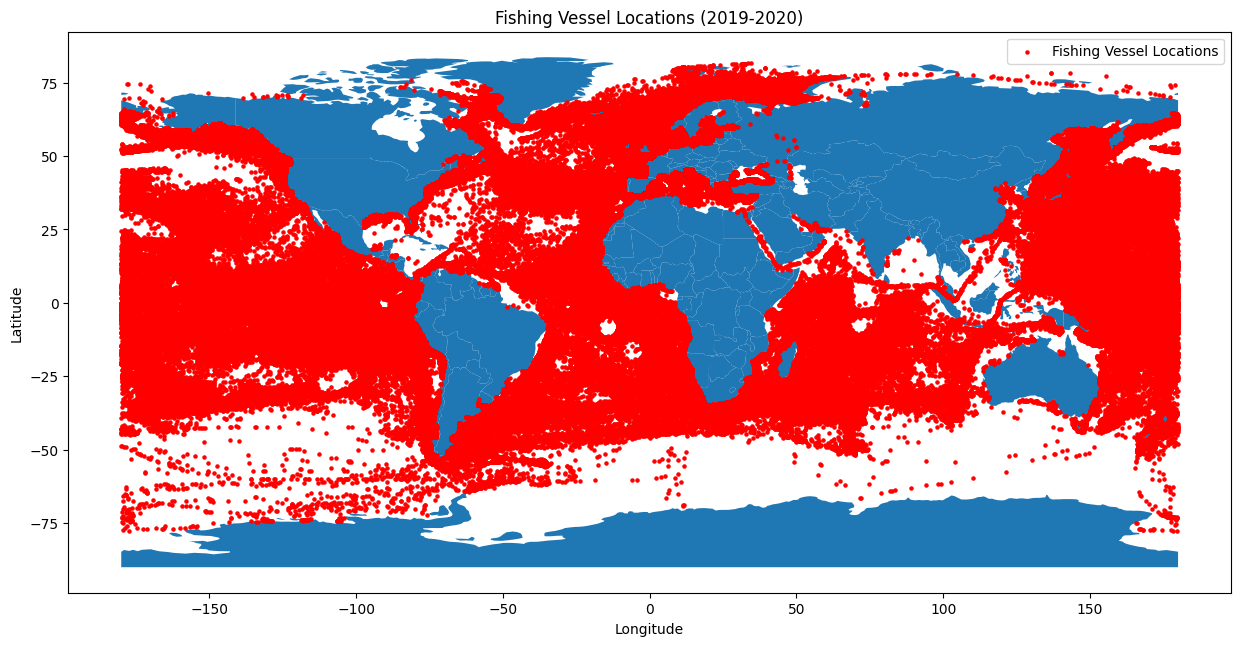

In [35]:
## All Data Sampled
sampled_df = df.sample(frac=0.01, random_state = 20)

geometry = [Point(lon, lat) for lon, lat in zip(sampled_df['cell_ll_lon'], sampled_df['cell_ll_lat'])]
gdf = gpd.GeoDataFrame(sampled_df, geometry=geometry)
gdf.set_crs("EPSG:4326", allow_override=True, inplace=True)

url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)

ax = world.plot(figsize=(15, 10))
gdf.plot(ax=ax, marker='o', color='red', markersize=5, label='Fishing Vessel Locations')

plt.title('Fishing Vessel Locations (2019-2020)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

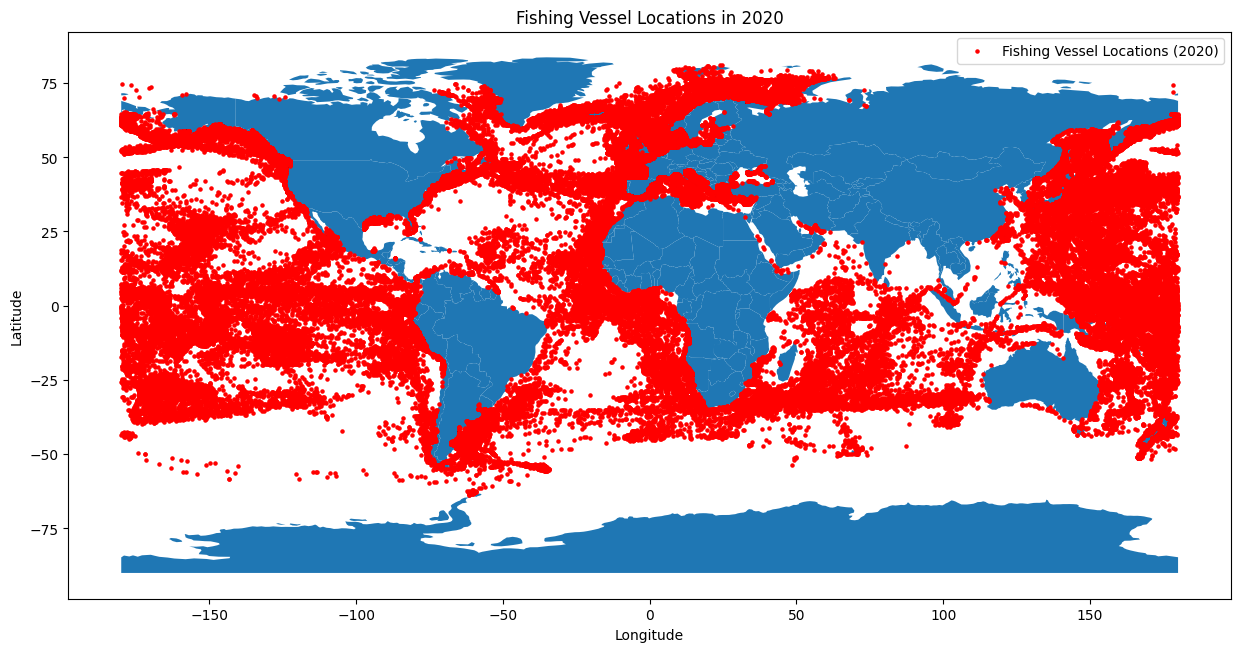

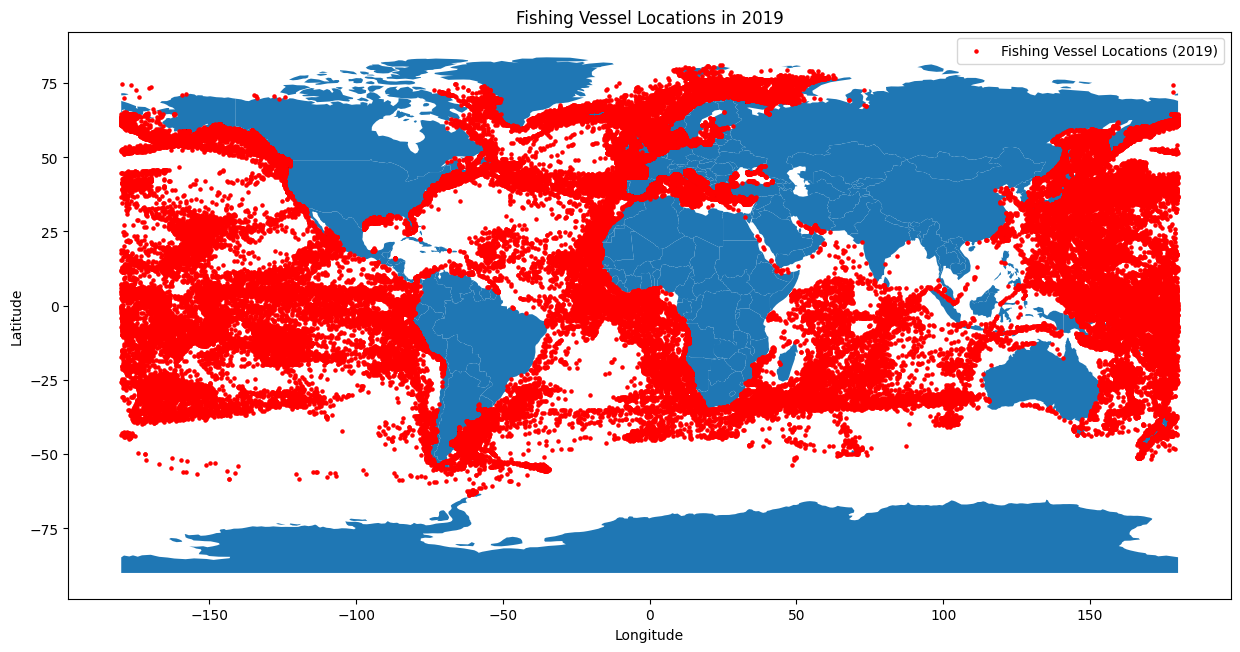

In [22]:
## Sample Data by Year
unique_years = [2020,2019]

for year in unique_years:
    yearly_df = df[df['year'] == year]
    yearly_df = yearly_df.sample(frac=0.01, random_state = 20)

    ax = world.plot(figsize=(15, 10))
    gdf.plot(ax=ax, marker='o', color='red', markersize=5, label=f'Fishing Vessel Locations ({year})')

    plt.title(f'Fishing Vessel Locations in {year}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()

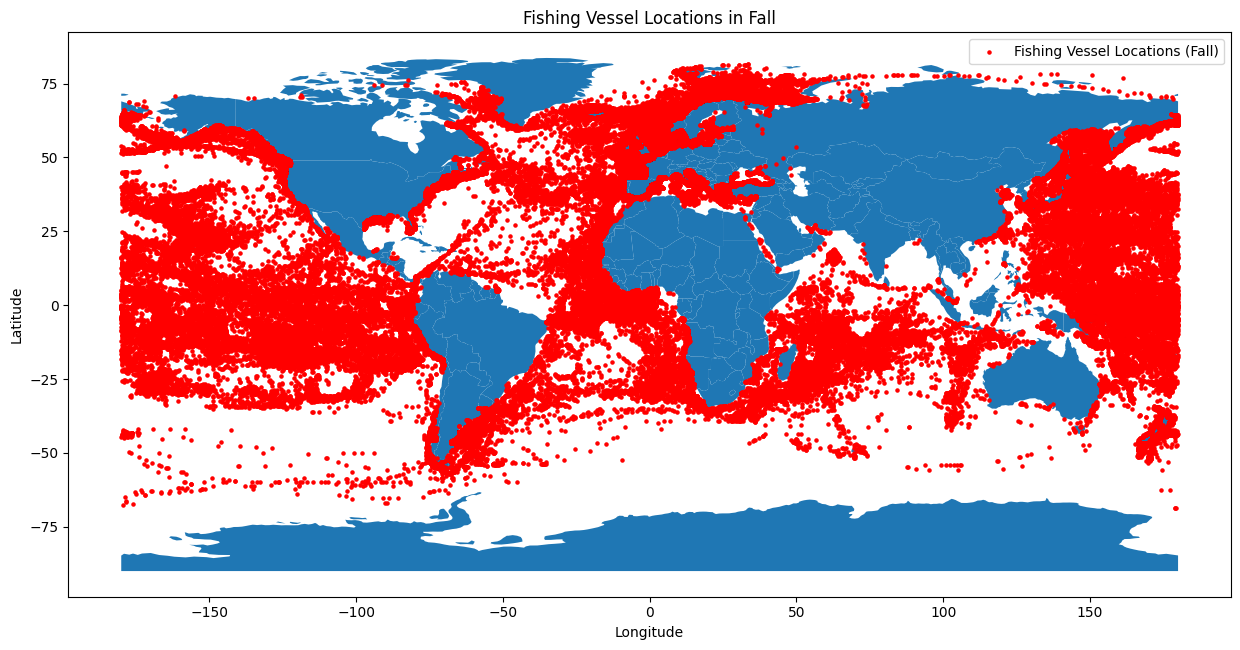

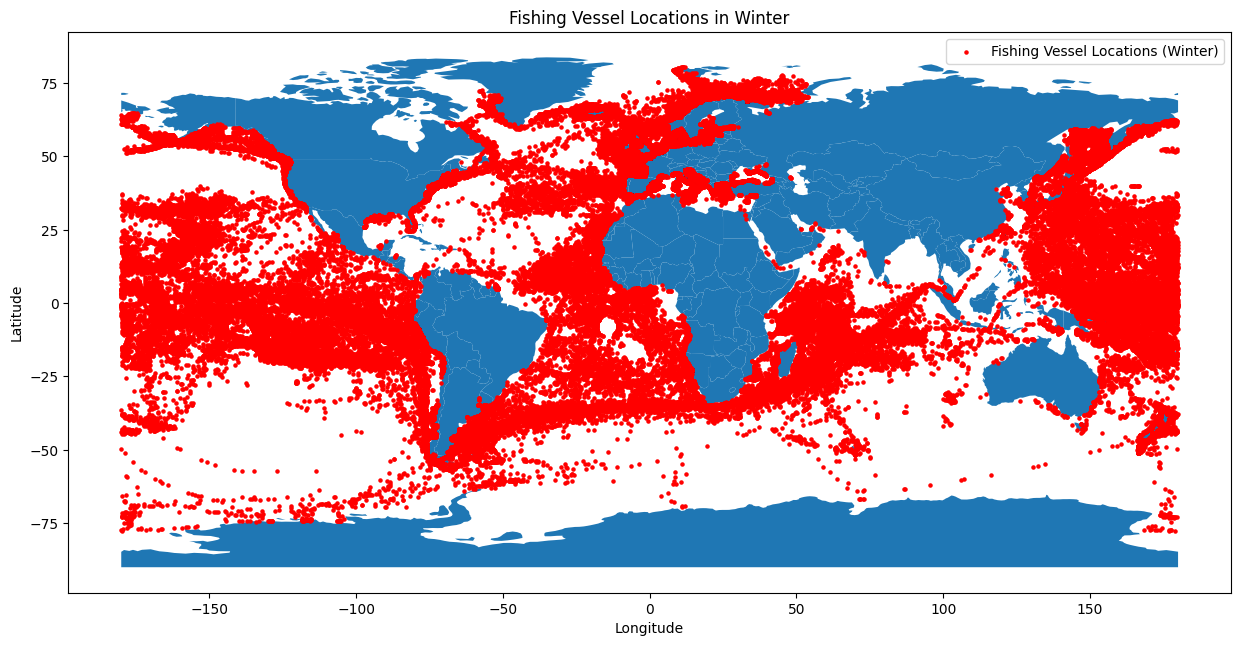

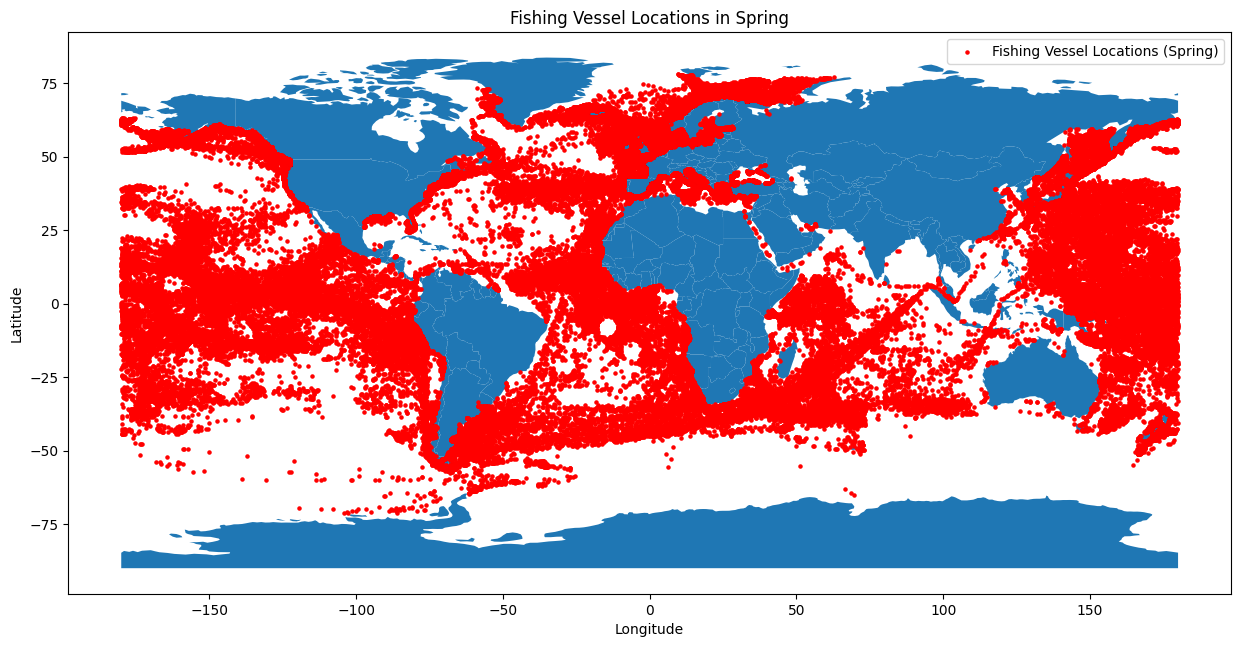

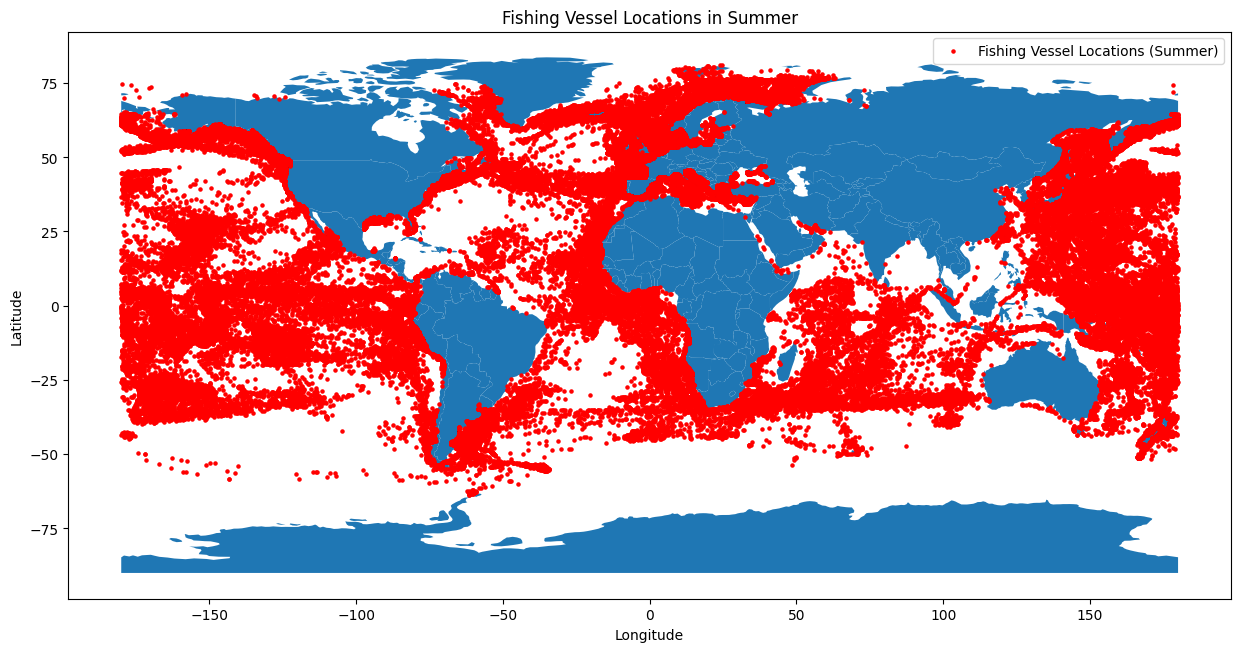

In [21]:
## Sampled Data by Season
seasons_list = ['Fall','Winter','Spring','Summer']

for season in seasons_list:
    season_df = df[df['season'] == season]
    sampled_df = season_df.sample(frac=0.01, random_state = 20)

    ax = world.plot(figsize=(15, 10))
    gdf.plot(ax=ax, marker='o', color='red', markersize=5, label=f'Fishing Vessel Locations ({season})')

    plt.title(f'Fishing Vessel Locations in {season}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()